In [1]:
import os
import cv2
import numpy as np
import keras
import tensorflow as tf
from keras import backend as K 
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt 
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt 
%matplotlib inline

Using TensorFlow backend.


In [2]:
input_path = './chest_xray/'

def process_data(img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    train_gen = train_datagen.flow_from_directory(
    directory=input_path+'train', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
    directory=input_path+'test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)
    
    
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            img = plt.imread(input_path+'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

In [3]:
train_gen, test_gen, test_data, test_labels = process_data(224, 32)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [4]:
from keras.applications.vgg19 import VGG19

In [5]:
vgg19 = VGG19(input_shape=[224, 224, 3], weights='imagenet', include_top=False)

In [6]:
for layer in vgg19.layers:
    layer.trainable=False

In [7]:
from keras.layers import Dropout
vgg_output = vgg19.output

flatten = Flatten()(vgg_output)
Dense_layer1 = Dense(units=128,activation='relu', bias_regularizer= regularizers.l1_l2(0.01, 0.01))(flatten)
Dropout_layer = Dropout(0.2)(Dense_layer1)
output_layer = Dense(1,activation='sigmoid')(Dropout_layer)

In [8]:
from keras.models import Model
model = Model(inputs=vgg19.input, outputs=output_layer)

In [9]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [10]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
train = model.fit_generator(train_gen, epochs=5, steps_per_epoch=326, validation_data=test_gen, validation_steps=test_gen.samples)

Epoch 1/5
326/326 [==============================] - 1216s 4s/step - loss: 0.3866 - accuracy: 0.8653 - val_loss: 0.5871 - val_accuracy: 0.8619
Epoch 2/5
326/326 [==============================] - 1451s 4s/step - loss: 0.2126 - accuracy: 0.9116 - val_loss: 0.6523 - val_accuracy: 0.8720
Epoch 3/5
326/326 [==============================] - 1468s 5s/step - loss: 0.1806 - accuracy: 0.9294 - val_loss: 0.3426 - val_accuracy: 0.8942
Epoch 4/5
326/326 [==============================] - 1468s 5s/step - loss: 0.1682 - accuracy: 0.9369 - val_loss: 0.3944 - val_accuracy: 0.8992
Epoch 5/5
326/326 [==============================] - 1474s 5s/step - loss: 0.1570 - accuracy: 0.9417 - val_loss: 0.3257 - val_accuracy: 0.8779


In [12]:
def plot_confusion_matrix(cm,classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
        
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

In [13]:
predictions = model.predict(test_data)

Confusion matrix, without normalization
[[206  28]
 [ 46 344]]


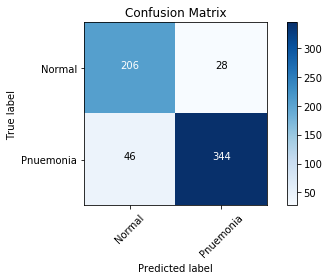

In [14]:
cm = confusion_matrix(test_labels, np.round(predictions[:,0]))
cm_plot_labels=['Normal','Pnuemonia']
plot_confusion_matrix(cm,cm_plot_labels,title='Confusion Matrix')

In [15]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, np.round(predictions[:,0])))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       234
           1       0.92      0.88      0.90       390

    accuracy                           0.88       624
   macro avg       0.87      0.88      0.88       624
weighted avg       0.88      0.88      0.88       624



In [16]:
model.save('VGG19(88%).h5')

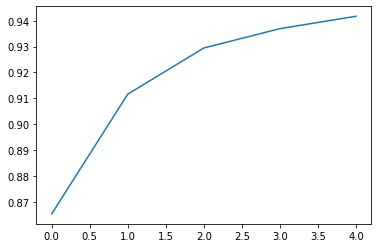

In [17]:
plt.plot(train.history['accuracy'])

In [18]:
model.evaluate_generator(test_gen, steps=32, verbose=0)

[0.5061283111572266, 0.8789682388305664]

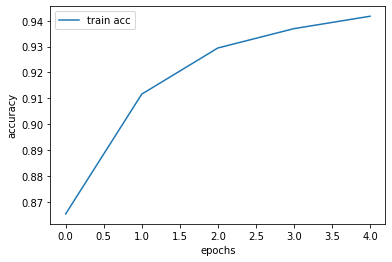

In [21]:
plt.plot(train.history['accuracy'], label='train acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [22]:
test_image = image.load_img('chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg', target_size = (224,224))
test_image = image.img_to_array(test_image)
test_image = test_image/255
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)

In [23]:
result

array([[0.95247656]], dtype=float32)

In [24]:
print(classification_report(test_labels, np.round(predictions[:,0]), target_names=['Normal','Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.82      0.88      0.85       234
   Pneumonia       0.92      0.88      0.90       390

    accuracy                           0.88       624
   macro avg       0.87      0.88      0.88       624
weighted avg       0.88      0.88      0.88       624



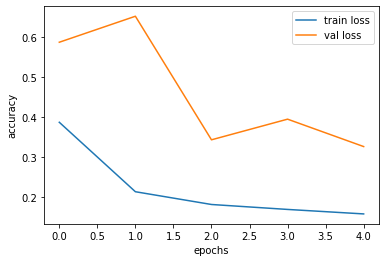

In [26]:
plt.plot(train.history['loss'], label='train loss')
plt.plot(train.history['val_loss'], label='val loss')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

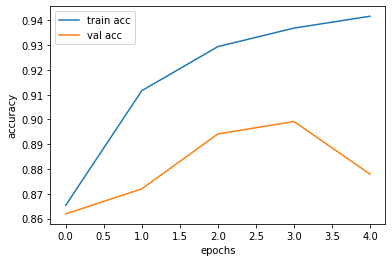

In [27]:
plt.plot(train.history['accuracy'], label='train acc')
plt.plot(train.history['val_accuracy'], label='val acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()